[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


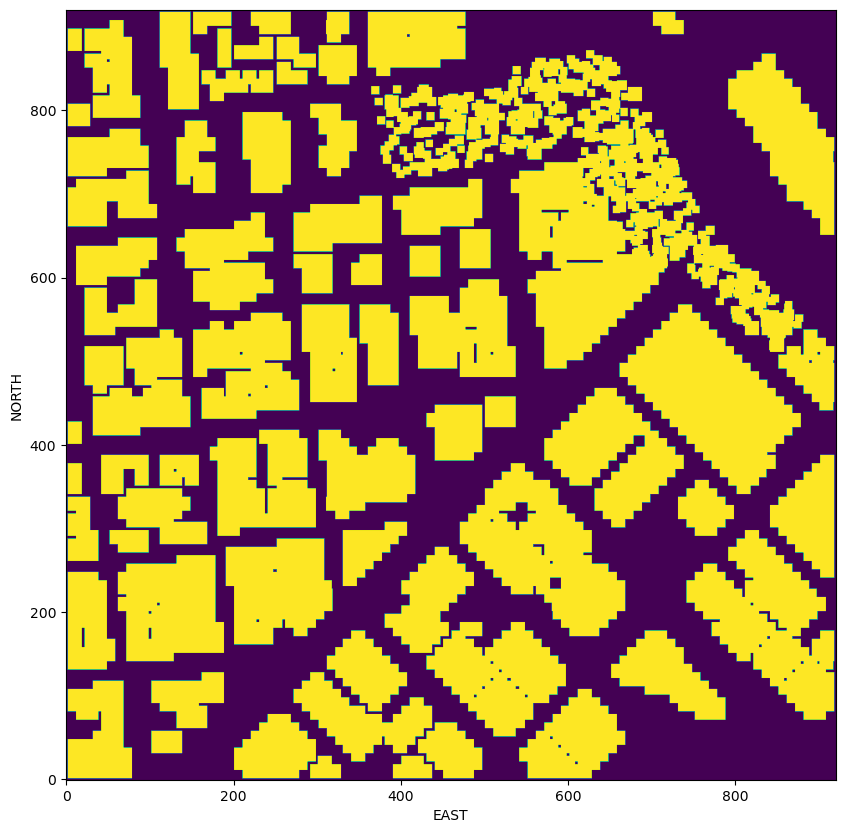

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

# Load a map of San Fransico, California.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=2)
"""
The first row in Colliders.csv is the lat, lon of the map's center.
The second row is "posX,posY,posZ,halfSizeX,halfSizeY,halfSizeZ"
The rows following that contain the corresponding information, measured in meters.

x -> North
y -> East
z -> Up
"""
print(data)
# Consider a 5 meter drone altitude. 
drone_altitude = 1
# Also, consider a 3 meter safe distance padding each obstacle.
safe_distance = 3

def create_grid(data, drone_altitude, safety_distance):
    """
    Inputs: data, 2d numpy array of obstacles and free space; 
        drone_altitude: drone altitude in meters above the ground;
        safety_distance: desired safety distance, in meters, around
            obstacles. 
    Returns: 2d configuration space
    """
    # First, calculate the minimum and maximum north coordinates.
    north_min = np.floor(np.amin(data[:,0] - data[:,3]))
    north_max = np.ceil(np.amax(data[:,0] + data[:,3]))

    # Second, calculate the minimum and maximum east coordinates.
    east_min = np.floor(np.amin(data[:,1] - data[:,4]))
    east_max = np.ceil(np.amax(data[:,1] + data[:,4]))

    # Third, calculate the grid's size.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Fourth, initialize an empty grid. 
    grid = np.zeros((north_size, east_size))
    
    # Fifth, establish grid offsetes. 
    north_min_center = np.min(data[:,0])
    east_min_center = np.min(data[:,1])
    
    # Sixth, populate the grid with obstacles. 
    # Consider each obstacle in data. Build a rectangle of 1-m's around it. 
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i,:]
        
        if (drone_altitude < alt + d_alt and drone_altitude > alt - d_alt):
            north_rel = north - north_min_center # How many meters north the obstacle is from home.
            east_rel = east - east_min_center # How many meters east the obstacle is from home. 

            north_index_min = int(north_rel - d_north - safety_distance)
            north_index_max = int(north_rel + d_north + safety_distance)
            east_index_min = int(east_rel - d_east - safety_distance)
            east_index_max = int(east_rel + d_east + safety_distance)

            # Only make it an obstacle if it's an obstacle at the given height.
            grid[north_index_min:north_index_max+1, east_index_min:east_index_max+1] = 1
        
        
    
    return grid

grid = create_grid(data, drone_altitude, safe_distance)
print(grid)
DF = pd.DataFrame(grid)
DF.to_csv("grid_output.csv")

plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [4]:
import numpy as np

M = np.array([[4, 1, 1, 5],
          [0, 5, -3, 7],
          [-5, -2, -1, 9],
             [4, 2, 1, 1]])
print(M)
print(M[0:2,1:3])


[[ 4  1  1  5]
 [ 0  5 -3  7]
 [-5 -2 -1  9]
 [ 4  2  1  1]]
[[ 1  1]
 [ 5 -3]]


In [5]:
from queue import PriorityQueue
import numpy as np
from enum import Enum

class Action(Enum):
    """
    This class defines the action set. Each action is a 3-element tuple where the first two elements describe
    the vertical and horizontal grid motions or translations, while the final element of the tuple describes
    the action's cost. 
    
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    NORTHEAST = (-1, 1, np.sqrt(2))
    NORTHWEST = (-1, -1, np.sqrt(2))
    SOUTHEAST = (1, 1, np.sqrt(2))
    SOUTHWEST = (1, -1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        elif self == self.NORTHEAST:
            return '*'
        elif self == self.NORTHWEST:
            return '*'
        elif self == self.SOUTHEAST:
            return '*'
        elif self == self.SOUTHWEST:
            return '*'
        
    @property
    def cost(self):
        return self.value[2]
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and given a node.
    """
    
    # This function defines some key parameters first.
    #potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN, Action.NORTHEAST, Action.NORTHWEST, Action.SOUTHEAST, Action.SOUTHWEST]
    potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    valid = []
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # Next, it iterates through each potential action, only considering it as a valid action if the action results in a location that is both on-grid and
    # non-obstacle.
    for action in potential:
        dx, dy = action.value[0], action.value[1]
        rx, ry = x + dx, y + dy
        if rx <= n and rx >= 0 and ry <=m and ry >= 0 and grid[rx, ry] != 1:
            valid.append(action)
        
    
    # Finally, this function returns a list of valid actions.     
    return valid

def visualize_path(grid, path, start):
    sgrid = np.zeros(np.shape(grid), dtype=str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    for a in path:
        da = a.value
        sgrid[pos[0] + da[0], pos[1] + da[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    
    return sgrid

def euclidean_heuristic(position, goal_position):
    """
    Computes and returns the straight-line distance between the a given node and a goal node.
    """
    h = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2) 
    return h

def manhattan_heuristic(position, goal_position):
    """
    Computes and returns the Manhattan distance between the given node and a goal node.
    """
    h = np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])
    return h

def a_star(grid, h, start, goal):
    """
    Executes A Star Search given a grid, heuristic array, a start goal, and an end goal. 
    Returns the path if one is found. 
    """
    
    # First, initializes data structures.
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Then, begins the A Star. The algorithm will expand the lowest queue-cost node, where queue-cost
    # is the sum of the heuristic cost and the path cost. 
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0.0
        else:
            current_cost = branch[current_node][0]
        
        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
    
    # After, retraces steps, returning the step-by-step actions and total path-cost required to get there.
    if found:
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2])
            n = branch[n][1]
        path.append(branch[n][2])
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
        
    return path[::-1], path_cost

    
    

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


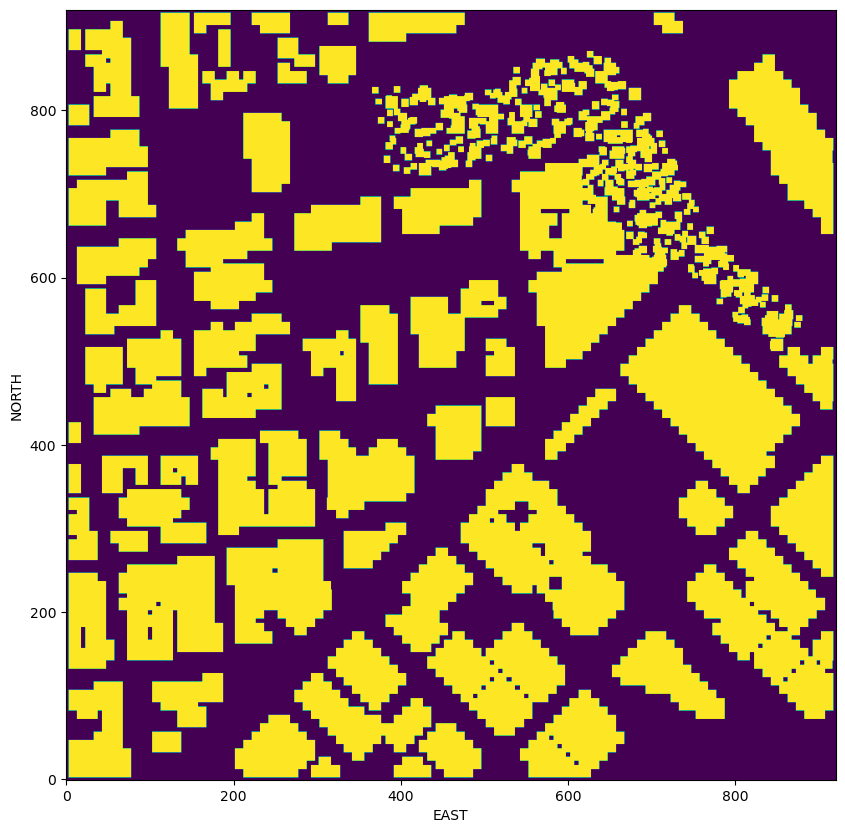

Found a path.
[<Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT

In [83]:
"""
This is the main script file for my planning project. 
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams["figure.figsize"] = [10, 10]
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=2)

drone_altitude = 5
safe_distance = 2

filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=2)


grid = create_grid(data, drone_altitude, safe_distance)
print(grid)

plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

start = (0, 0)
goal = (300, 650)
path, cost = a_star(grid, euclidean_heuristic, start, goal)
print(path, cost)
vis = visualize_path(grid, path, start)

print("complete.")


In [84]:
vis_bool = np.zeros(np.shape(vis))
for i in range(np.shape(vis)[0]):
    for j in range(np.shape(vis)[1]):
        if vis[i,j] == 'S' or vis[i, j] == 'G' or vis[i,j] == '>' or vis[i,j] == 'v' or vis[i,j] == '<' or vis[i,j] == '^'  or vis[i,j] == '*':
            vis_bool[i, j] = 10
print(vis_bool)

[[10. 10. 10. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


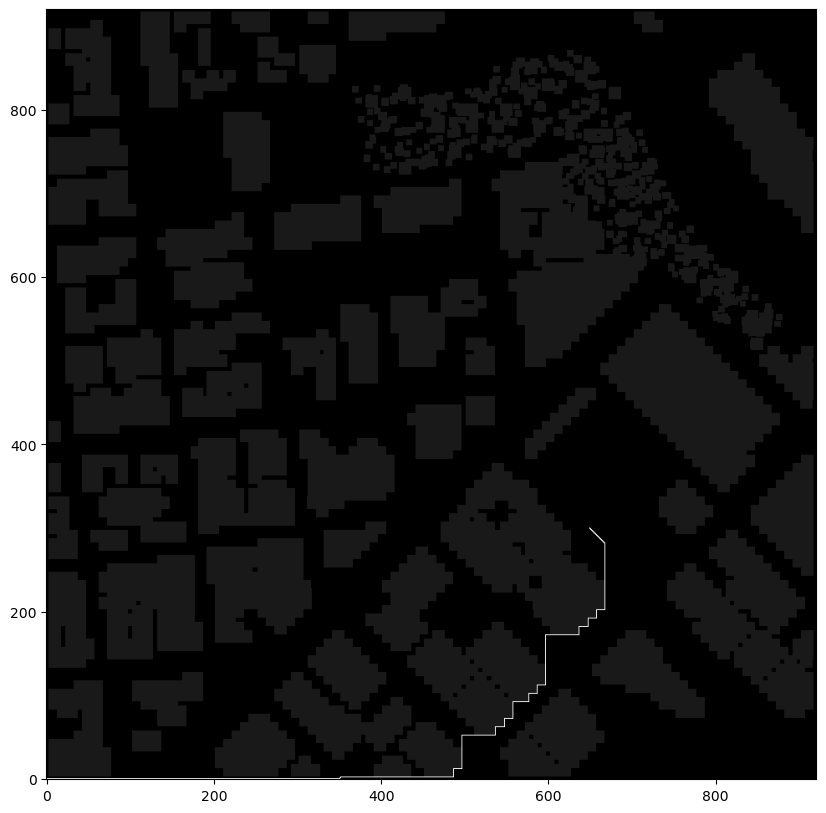

In [85]:
plt.imshow(grid + vis_bool, origin='lower', cmap="gray")